In [1]:
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
from scipy.interpolate import CubicSpline
import copy
import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *
from GLODAP_gridding_tools import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/observations/" + x

## Load in GLODAPv2

In [3]:
ds = pd.read_csv(datadir('GLODAPv2.2023_Merged_Master_File.csv'),na_values=9999)
ds = ds.replace(-9999, np.nan)

/tmp/ipykernel_238113/2440561600.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  ds = pd.read_csv(datadir('GLODAPv2.2023_Merged_Master_File.csv'),na_values=9999)


In [4]:
np.nanmin(ds["G2cfc12"]), np.nanmax(ds["G2cfc12"])

(np.float64(-0.07), np.float64(5.26))

In [5]:
ds["G2longitude"].iloc[np.where(ds["G2longitude"] > 180)[0]] -= 360 #fix points

/tmp/ipykernel_238113/1034382165.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ds["G2longitude"].iloc[np.where(ds["G2longitude"] > 180)[0]] -= 360 #fix points
/tmp/ipykernel_238113/1034382165.py:1: SettingWithCopyWarning: 
A value is t

In [6]:
ds["G2longitude"].max()

180.0

## Select objective grid, variables and year 

In [7]:
regular_lon = np.arange(-180, 180, 2)
regular_lat = np.arange(-90, 90, 2)
gridded_z = np.arange(10, 5000, 75)
varns = ["G2cfc12", "G2cfc11", "G2sf6", "G2temperature", "G2salinity"]
vars_dicts, casts_dict = GLODAP_2_regular_grid(ds, gridded_z, regular_lat, regular_lon, 
                                            varns = varns, year = 2020.)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

## Compare original observations and the gridded data 

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: shading value 'auto|' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


Text(0.5, 1.0, '2° x 2° Gridded Data')

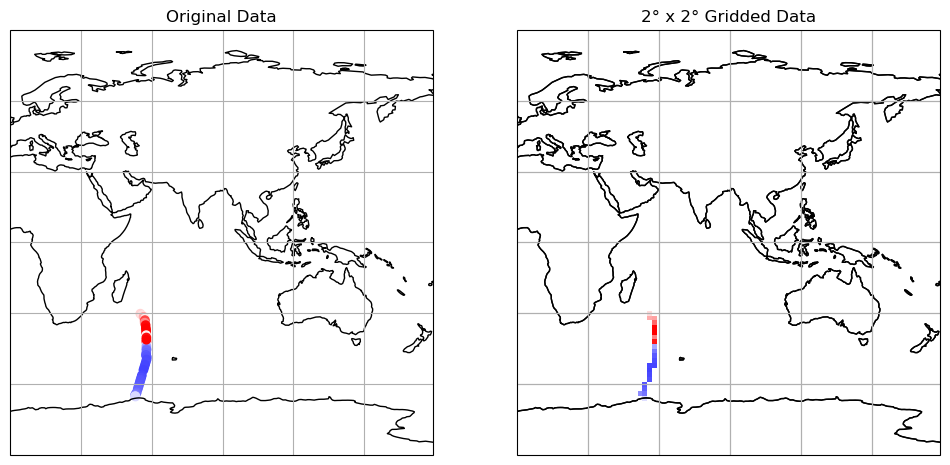

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree()})

[a.set_extent([0, 179, -90, 90], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

axes[0].scatter(casts_dict["G2cfc12"].lon[:], 
                casts_dict["G2cfc12"].lat[:], 
                c = casts_dict["G2cfc12"].G2cfc12[17, :][:], vmin = 0, vmax = 1, transform=ccrs.PlateCarree(), cmap = "bwr")

axes[1].pcolormesh(vars_dicts["G2cfc12"].lon,
                   vars_dicts["G2cfc12"].lat, 
                   vars_dicts["G2cfc12"].G2cfc12[:, :, 17].T, 
                   vmin = 0, vmax = 1, 
                   transform=ccrs.PlateCarree(), cmap = "bwr", shading="auto|")

axes[1].set_extent([0, 179, -90, 90], ccrs.PlateCarree())
axes[1].gridlines()
axes[1].coastlines()

axes[0].set_title("Original Data")
axes[1].set_title("2° x 2° Gridded Data")

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: shading value 'auto|' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


Text(0.5, 1.0, '2° x 2° Gridded Data')

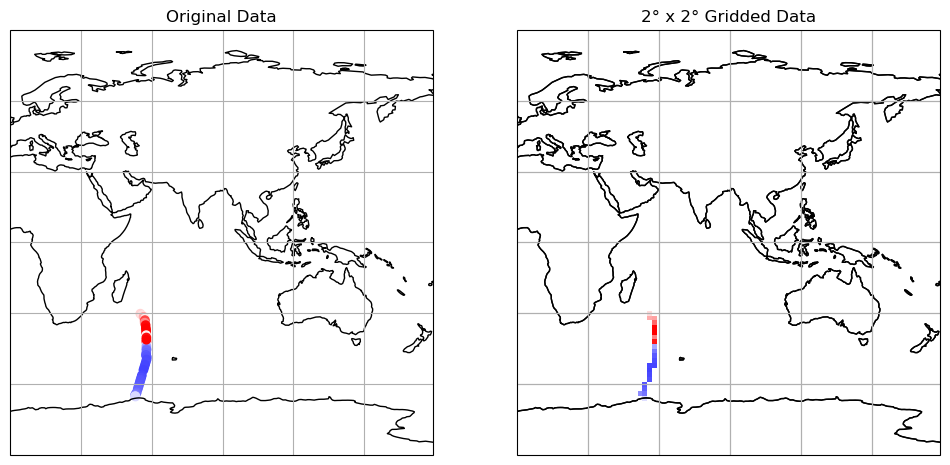

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree()})

[a.set_extent([0, 179, -90, 90], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

axes[0].scatter(casts_dict["G2cfc12"].lon[:], 
                casts_dict["G2cfc12"].lat[:], 
                c = casts_dict["G2cfc12"].G2cfc12[17, :][:], vmin = 0, vmax = 1, transform=ccrs.PlateCarree(), cmap = "bwr")

axes[1].pcolormesh(vars_dicts["G2cfc12"].lon,
                   vars_dicts["G2cfc12"].lat, 
                   vars_dicts["G2cfc12"].G2cfc12[:, :, 17].T, 
                   vmin = 0, vmax = 1, 
                   transform=ccrs.PlateCarree(), cmap = "bwr", shading="auto|")

axes[1].set_extent([0, 179, -90, 90], ccrs.PlateCarree())
axes[1].gridlines()
axes[1].coastlines()

axes[0].set_title("Original Data")
axes[1].set_title("2° x 2° Gridded Data")

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: shading value 'auto|' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


Text(0.5, 1.0, '2° x 2° Gridded Data')

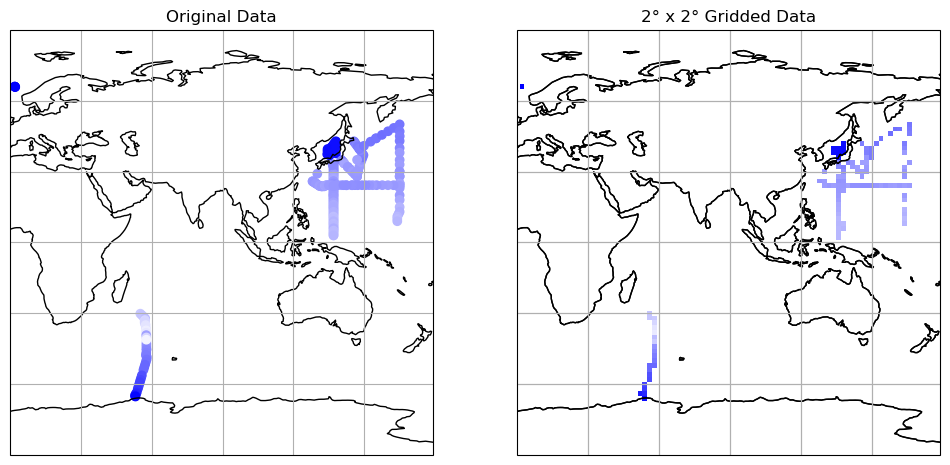

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree()})

[a.set_extent([0, 179, -90, 90], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

axes[0].scatter(casts_dict["G2temperature"].lon[:], 
                casts_dict["G2temperature"].lat[:], 
                c = casts_dict["G2temperature"].G2temperature[17, :][:], vmin = 0, vmax = 10, transform=ccrs.PlateCarree(), cmap = "bwr")

axes[1].pcolormesh(vars_dicts["G2temperature"].lon,
                   vars_dicts["G2temperature"].lat, 
                   vars_dicts["G2temperature"].G2temperature[:, :, 17].T, 
                   vmin = 0, vmax = 10, 
                   transform=ccrs.PlateCarree(), cmap = "bwr", shading="auto|")

axes[1].set_extent([0, 179, -90, 90], ccrs.PlateCarree())
axes[1].gridlines()
axes[1].coastlines()

axes[0].set_title("Original Data")
axes[1].set_title("2° x 2° Gridded Data")

## Create a grid for all years 

In [11]:
regular_lon = np.arange(-180, 180, 2)
regular_lat = np.arange(-90, 90, 2)
gridded_z = np.arange(10, 5000, 50)

varns = ["G2cfc12", "G2cfc11", "G2sf6", "G2temperature", "G2salinity"]

tregvars = dict()
tcastvars =  dict()
year_range = range(1990, 2021)
for (tt, y) in enumerate(year_range):
    print("Percent Completed: ", tt / len(year_range))
    
    vars_dicts, casts_dict = GLODAP_2_regular_grid(ds, gridded_z, regular_lat, regular_lon, 
                                                varns = varns, year = y)
    vars_dicts = xr.merge(vars_dicts.values())
    tregvars[y] = vars_dicts

tmp_list = []
for val in tregvars.values():
    tmp_list += [val.assign_coords({"time":val.time })]

#save gridded data 
GLODAP_gridded = xr.concat(tmp_list, dim = "time")
GLODAP_gridded.to_netcdf("GLODAP_gridded.nc", compute = True)

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Percent Completed:  0.0


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Percent Completed:  0.03225806451612903


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.06451612903225806


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.0967741935483871


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.12903225806451613


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.16129032258064516


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.1935483870967742


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.22580645161290322


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.25806451612903225


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.2903225806451613


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.3225806451612903


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.3548387096774194


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.3870967741935484


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.41935483870967744


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.45161290322580644


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.4838709677419355


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.5161290322580645


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.5483870967741935


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.5806451612903226


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.6129032258064516


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.6451612903225806


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.6774193548387096


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.7096774193548387


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.7419354838709677


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.7741935483870968


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.8064516129032258


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.8387096774193549


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.8709677419354839


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.9032258064516129


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.9354838709677419


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

Percent Completed:  0.967741935483871


/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value enc

## Plot composites

In [12]:
cfc_gridded = GLODAP_gridded["G2cfc12"]

Text(0.5, 1.0, 'CFC12 (2010 — 2020)')

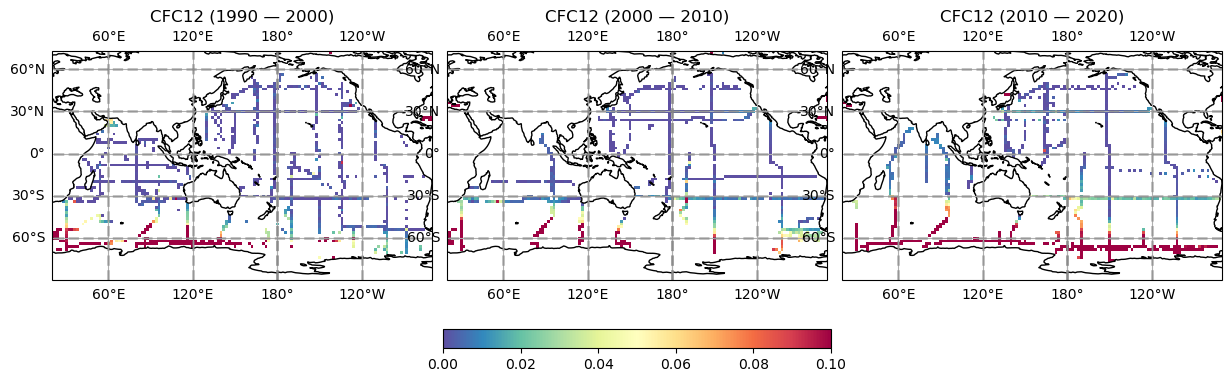

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})
[a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

cfc_gridded.sel(time = slice(1990, 2000), z = slice(3000, 4000)).T.mean(["time", "z"]).plot.pcolormesh(ax=axes[0], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())

cm = cfc_gridded.sel(time = slice(2000, 2010), z = slice(3000, 4000)).T.mean(["time", "z"]).plot.pcolormesh(ax=axes[1], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
cfc_gridded.sel(time = slice(2010, 2020), z = slice(3000, 4000)).T.mean(["time", "z"]).plot.pcolormesh(ax=axes[2], 
                                                                                                             vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                                                             add_colorbar = False, transform = ccrs.PlateCarree())
fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05)

[a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--') for a in axes]

axes[0].set_title("CFC12 (1990 — 2000)")
axes[1].set_title("CFC12 (2000 — 2010)")
axes[2].set_title("CFC12 (2010 — 2020)")